# Gamma ray spectrometry: peak identification by curve fitting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = ['Times New Roman']
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['mathtext.fontset'] = 'stix'
from scipy.optimize import curve_fit

## Importing the spectra

In [2]:
isotopes = ['Am241', 'Ba133', 'Co60', 'Cs137', 'Eu152', 'Na22']
spectra = pd.DataFrame()
for isotope in isotopes:
    spectra[isotope] = pd.read_csv(
        'data_20220302/{:s}.Spe'.format(isotope), skiprows=12,
        nrows=2048, names=['counts'])

spectra.head(10)

,Am241,Ba133,Co60,Cs137,Eu152,Na22
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,8,4,21,11,91,11
3,573,262,110,354,1021,197
4,6384,2585,1804,1650,7046,826
5,9398,3389,2662,1909,9031,898
6,10332,4085,2685,2015,8902,890
7,11943,4881,2698,2033,9165,916
8,13353,5833,2813,2064,9811,983
9,15438,7020,2770,2025,10503,958


## Fitting functions

In [3]:
def lorentzian(x, position, fwhm, maximum, base):
    xprime = (x - position)/(fwhm/2)
    return maximum/(1 + xprime**2) + base

def double_lorentzian(x, *args):
    return lorentzian(x, *args[:4]) + lorentzian(x, *[*args[4:], args[3]])

def gaussian(x, position, fwhm, maximum, base):
    sigma = fwhm/(2*np.sqrt(2*np.log(2)))
    return maximum*np.exp(-(x - position)**2/(2*sigma**2)) + base

In [4]:
def fit_peaks(data, slices, func=lorentzian):
    """
    Fits Lorentzian curves to peaks.
    
    Args:
        data: Gamma spectrum as an array.
        slices: List of slices defining peaks to be fitted.
        
    Returns:
        channels: List of 1D arrays containing the channel numbers
            corresponding to `slices`.
        params: N by 4 array containing the fit parameters (position,
            fwhm, maximum, base) for each peak, where N is the number
            of peaks.
        delta_params: Corresponding N by 4 array of uncertainties.
        fits: List of 1D arrays containing the values of the best-fit
            curves at the points in `channels`.
        residuals: Corresponsing list of 1D arrays of residuals.
        r_squared: Array containing the r-squared value for each fit.
    """
    channels = [np.arange(slice_.start, slice_.stop) for slice_ in slices]
    params = np.zeros((len(slices), 4))
    delta_params = np.zeros((len(slices), 4))
    r_squared = np.zeros(len(slices))
    fits = []
    
    for i, slice_ in enumerate(slices):
        p0 = (channels[i].mean(), (channels[i].max() - channels[i].min())/2,
              data[slice_].max(), 0)
        params[i,:], cov = curve_fit(
            func, xdata=channels[i], ydata=data[slice_],
            sigma=np.sqrt(data[slice_]), absolute_sigma=True, p0=p0,
            bounds=([-np.inf, -np.inf, -np.inf, 0], np.inf))
        delta_params[i,:] = np.sqrt(np.diag(cov))

        fit = lorentzian(channels[i], *params[i,:])
        residuals = data[slice_] - fit
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((data[slice_]
                         - np.mean(data[slice_]))**2)

        r_squared[i] = 1 - ss_res/ss_tot
        fits.append(fit)
        
    return channels, params, delta_params, fits, residuals, r_squared

## Eu-152 spectrum

In [5]:
slices = [
    slice(1220, 1400), slice(960, 1070), slice(840, 950),
    slice(660, 840), slice(280, 355), slice(195, 255),
    slice(95, 125), slice(50, 75), slice(23, 43),
]
(channels, params, delta_params,
 fits, residuals, r_squared) = fit_peaks(spectra.Eu152, slices)

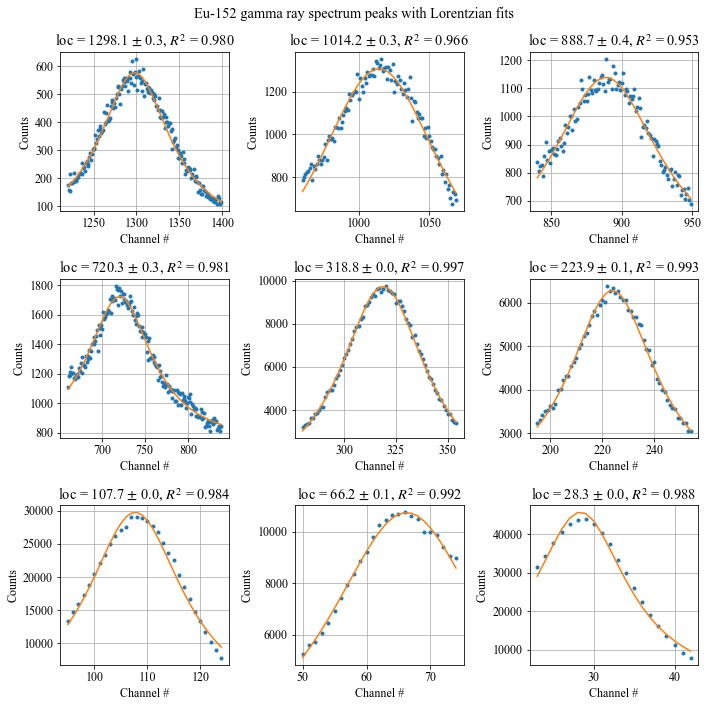

In [6]:
fig, axes = plt.subplots(3, 3, figsize=(10,10))

for i, ax, in enumerate(axes.ravel()):
    ax.plot(channels[i], spectra.Eu152[slices[i]], marker='.', linestyle='')
    ax.plot(channels[i], fits[i])
    ax.grid()
    title = (
        'loc = {:.1f} $\\pm$ {:.1f}, $R^2$ = {:.3f}'
    ).format(params[i,0], delta_params[i,0], r_squared[i])
    ax.set(xlabel='Channel #', ylabel='Counts', title=title)

fig.suptitle('Eu-152 gamma ray spectrum peaks with Lorentzian fits')
fig.tight_layout()

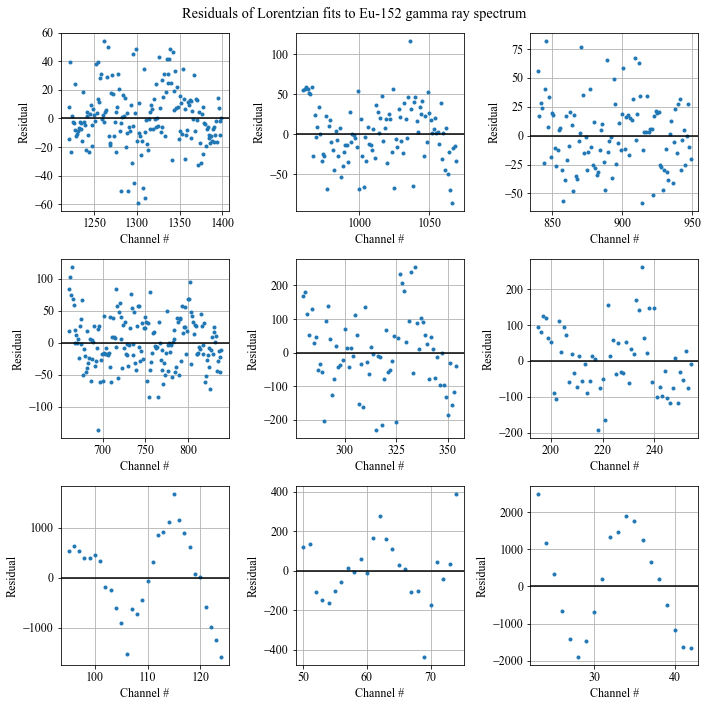

In [7]:
fig, axes = plt.subplots(3, 3, figsize=(10,10))

for i, ax, in enumerate(axes.ravel()):
    ax.plot(channels[i], spectra.Eu152[slices[i]] - fits[i],
            marker='.', linestyle='')
    ax.axhline(0, color='k')
    ax.grid()
    ax.set(xlabel='Channel #', ylabel='Residual')

fig.suptitle('Residuals of Lorentzian fits to Eu-152 gamma ray spectrum')
fig.tight_layout()

In [8]:
eu152_peaks = pd.DataFrame({
    'channel': params[:,0], 'delta_channel': delta_params[:,0],
    'fwhm': params[:,1], 'delta_fwhm': delta_params[:,1],
    'maximum': params[:,2], 'base': params[:,3],
    'energy': np.array([
        1408.024, 1112.085, 964.040, 778.872,
        344.274, 244.697, 121.783, 74.969, 39.9062,
    ]),
    'delta_energy': np.array([
        0.030, 0.020, 0.015, 0.015, 0.012, 0.012, 0.009, 0.005, 0.0005,
    ]),
    'r_squared': r_squared,
    'isotope': np.full(params.shape[0], 'Eu152')
})
eu152_peaks

,channel,delta_channel,fwhm,delta_fwhm,maximum,base,energy,delta_energy,r_squared,isotope
0,1298.119834,0.270729,101.143701,2.177328,576.250350,1.174011e-16,1408.0240,0.0300,0.980406,Eu152
1,1014.206403,0.264510,115.654695,7.715832,1227.996259,7.813527e+01,1112.0850,0.0200,0.965879,Eu152
2,888.702007,0.394580,95.869292,6.670586,701.780349,4.365925e+02,964.0400,0.0150,0.953075,Eu152
3,720.311948,0.303438,92.686610,1.874947,999.013956,7.223917e+02,778.8720,0.0150,0.980729,Eu152
4,318.801279,0.049167,50.988925,0.598528,9578.410289,1.417648e+02,344.2740,0.0120,0.997492,Eu152
5,223.906190,0.077745,41.436443,0.995012,4728.375339,1.543726e+03,244.6970,0.0120,0.992786,Eu152
6,107.731906,0.019711,22.207926,0.234797,29745.552575,4.195858e-12,121.7830,0.0090,0.984165,Eu152
7,66.246144,0.068993,30.959302,1.123389,10751.879956,1.446583e-12,74.9690,0.0050,0.991818,Eu152
8,28.345734,0.015282,14.155783,0.101866,45753.017482,2.772123e-16,39.9062,0.0005,0.988014,Eu152


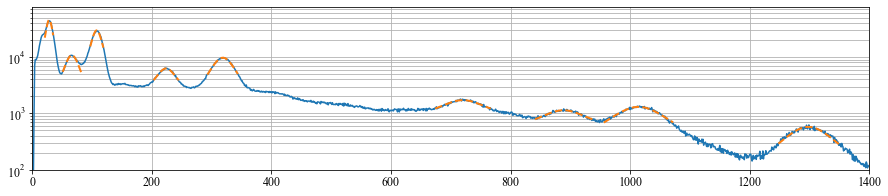

In [9]:
fig, ax = plt.subplots(figsize=(15,3))
ax.semilogy(spectra.Eu152)
params = eu152_peaks[['channel', 'fwhm', 'maximum', 'base']].to_numpy()
for i in range(eu152_peaks.shape[0]):
    channel, fwhm, maximum, base = params[i,:]
    fit_x = np.arange(np.round(channel-fwhm/2), np.round(channel+fwhm/2)+1)
    fit_y = lorentzian(fit_x, channel, fwhm, maximum, base)
    ax.plot(fit_x, fit_y, color='tab:orange', linestyle='--', linewidth=2)
ax.set_xlim(0, 1400)
ax.set_ylim(bottom=1e2)
ax.grid(True, which='both')

## Na-22 spectrum

In [10]:
slices = [slice(35, 80), slice(425, 510), slice(1100, 1250)]
(channels, params, delta_params,
 fits, residuals, r_squared) = fit_peaks(spectra.Na22, slices)

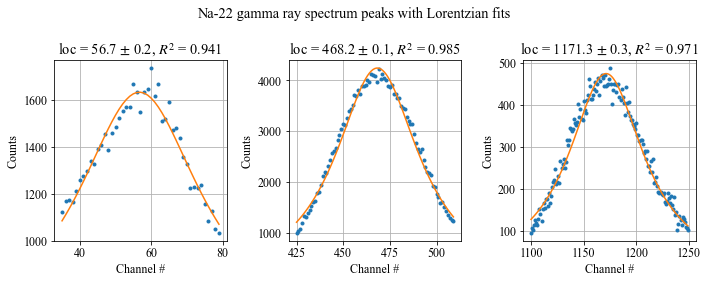

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

for i, ax, in enumerate(axes.ravel()):
    ax.plot(channels[i], spectra.Na22[slices[i]], marker='.', linestyle='')
    ax.plot(channels[i], fits[i])
    ax.grid()
    title = (
        'loc = {:.1f} $\\pm$ {:.1f}, $R^2$ = {:.3f}'
    ).format(params[i,0], delta_params[i,0], r_squared[i])
    ax.set(xlabel='Channel #', ylabel='Counts', title=title)

fig.suptitle('Na-22 gamma ray spectrum peaks with Lorentzian fits')
fig.tight_layout()

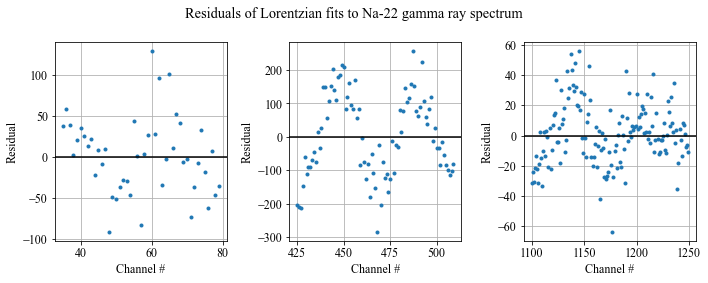

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

for i, ax, in enumerate(axes.ravel()):
    ax.plot(channels[i], spectra.Na22[slices[i]] - fits[i],
            marker='.', linestyle='')
    ax.axhline(0, color='k')
    ax.grid()
    ax.set(xlabel='Channel #', ylabel='Residual')

fig.suptitle('Residuals of Lorentzian fits to Na-22 gamma ray spectrum')
fig.tight_layout()

In [13]:
na22_peaks = pd.DataFrame({
    'channel': params[:,0], 'delta_channel': delta_params[:,0],
    'fwhm': params[:,1], 'delta_fwhm': delta_params[:,1],
    'maximum': params[:,2], 'base': params[:,3],
    'energy': np.array([72.804, 511.006, 1274.511]),
    'delta_energy': np.array([0.005, 0.01, 0.028]),
    'r_squared': r_squared,
    'isotope': np.full(params.shape[0], 'Na22'),
})
na22_peaks

,channel,delta_channel,fwhm,delta_fwhm,maximum,base,energy,delta_energy,r_squared,isotope
0,56.700843,0.204062,42.203178,4.640512,1066.236044,5.658983e+02,72.804,0.005,0.940758,Na22
1,468.245340,0.074298,54.636487,0.822857,4243.400022,6.097391e-15,511.006,0.010,0.985017,Na22
2,1171.305370,0.271475,86.801629,2.543608,474.804583,1.940372e-13,1274.511,0.028,0.970859,Na22


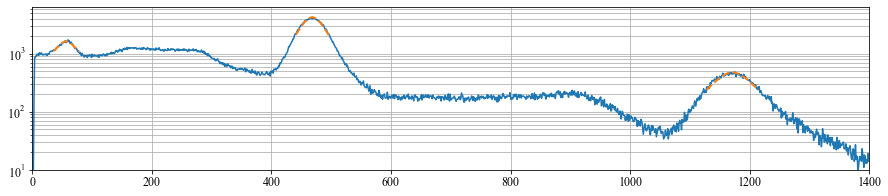

In [14]:
fig, ax = plt.subplots(figsize=(15,3))
ax.semilogy(spectra.Na22)
params = na22_peaks[['channel', 'fwhm', 'maximum', 'base']].to_numpy()
for i in range(na22_peaks.shape[0]):
    channel, fwhm, maximum, base = params[i,:]
    fit_x = np.arange(np.round(channel-fwhm/2), np.round(channel+fwhm/2)+1)
    fit_y = lorentzian(fit_x, channel, fwhm, maximum, base)
    ax.plot(fit_x, fit_y, color='tab:orange', linestyle='--', linewidth=2)
ax.set_xlim(0, 1400)
ax.set_ylim(bottom=10)
ax.grid(True, which='both')

## Cs-137 spectrum

In [15]:
slices = [slice(15, 35), slice(40, 90), slice(565, 660)]
(channels, params, delta_params,
 fits, residuals, r_squared) = fit_peaks(spectra.Cs137, slices)

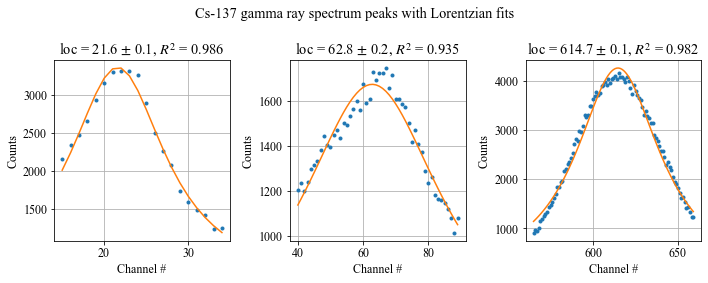

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

for i, ax, in enumerate(axes.ravel()):
    ax.plot(channels[i], spectra.Cs137[slices[i]], marker='.', linestyle='')
    ax.plot(channels[i], fits[i])
    ax.grid()
    title = (
        'loc = {:.1f} $\\pm$ {:.1f}, $R^2$ = {:.3f}'
    ).format(params[i,0], delta_params[i,0], r_squared[i])
    ax.set(xlabel='Channel #', ylabel='Counts', title=title)

fig.suptitle('Cs-137 gamma ray spectrum peaks with Lorentzian fits')
fig.tight_layout()

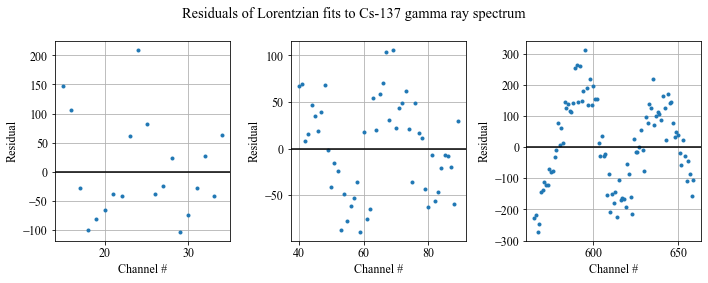

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

for i, ax, in enumerate(axes.ravel()):
    ax.plot(channels[i], spectra.Cs137[slices[i]] - fits[i],
            marker='.', linestyle='')
    ax.axhline(0, color='k')
    ax.grid()
    ax.set(xlabel='Channel #', ylabel='Residual')

fig.suptitle('Residuals of Lorentzian fits to Cs-137 gamma ray spectrum')
fig.tight_layout()

In [18]:
cs137_peaks = pd.DataFrame({
    'channel': params[:,0], 'delta_channel': delta_params[:,0],
    'fwhm': params[:,1], 'delta_fwhm': delta_params[:,1],
    'maximum': params[:,2], 'base': params[:,3],
    'energy': np.array([32.0611, 74.969, 661.638]),
    'delta_energy': np.array([0.0005, 0.005, 0.019]),
    'r_squared': r_squared,
    'isotope': np.full(params.shape[0], 'Cs137')
})
cs137_peaks

,channel,delta_channel,fwhm,delta_fwhm,maximum,base,energy,delta_energy,r_squared,isotope
0,21.592150,0.059779,13.885788,0.491952,2855.222295,5.036837e+02,32.0611,0.0005,0.986402,Cs137
1,62.793524,0.211742,53.026167,5.710671,1261.274014,4.132783e+02,74.9690,0.0050,0.935479,Cs137
2,614.667917,0.078285,60.204799,0.818218,4253.695638,4.986169e-14,661.6380,0.0190,0.981637,Cs137


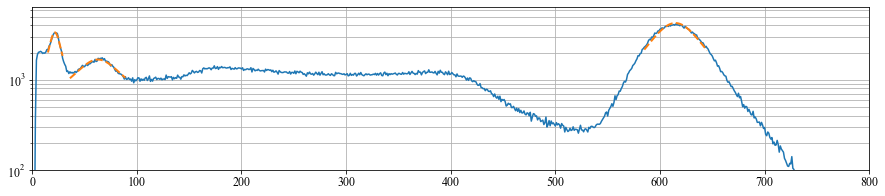

In [19]:
fig, ax = plt.subplots(figsize=(15,3))
ax.semilogy(spectra.Cs137)
params = cs137_peaks[['channel', 'fwhm', 'maximum', 'base']].to_numpy()
for i in range(cs137_peaks.shape[0]):
    channel, fwhm, maximum, base = params[i,:]
    fit_x = np.arange(np.round(channel-fwhm/2), np.round(channel+fwhm/2)+1)
    fit_y = lorentzian(fit_x, channel, fwhm, maximum, base)
    ax.plot(fit_x, fit_y, color='tab:orange', linestyle='--', linewidth=2)
ax.set_xlim(0, 800)
ax.set_ylim(bottom=100)
ax.grid(True, which='both')

## Am-241 spectrum

In [20]:
slices = [slice(7, 28), slice(40, 60)]
(channels, params, delta_params,
 fits, residuals, r_squared) = fit_peaks(spectra.Am241, slices)

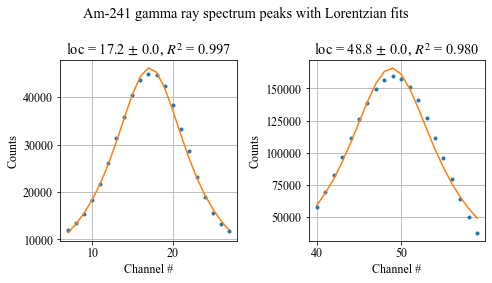

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4))

for i, ax, in enumerate(axes.ravel()):
    ax.plot(channels[i], spectra.Am241[slices[i]], marker='.', linestyle='')
    ax.plot(channels[i], fits[i])
    ax.grid()
    title = (
        'loc = {:.1f} $\\pm$ {:.1f}, $R^2$ = {:.3f}'
    ).format(params[i,0], delta_params[i,0], r_squared[i])
    ax.set(xlabel='Channel #', ylabel='Counts', title=title)

fig.suptitle('Am-241 gamma ray spectrum peaks with Lorentzian fits')
fig.tight_layout()

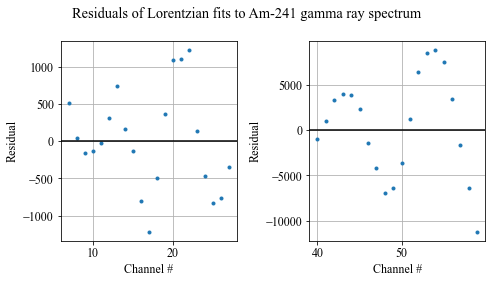

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4))

for i, ax, in enumerate(axes.ravel()):
    ax.plot(channels[i], spectra.Am241[slices[i]] - fits[i],
            marker='.', linestyle='')
    ax.axhline(0, color='k')
    ax.grid()
    ax.set(xlabel='Channel #', ylabel='Residual')

fig.suptitle('Residuals of Lorentzian fits to Am-241 gamma ray spectrum')
fig.tight_layout()

In [23]:
am241_peaks = pd.DataFrame({
    'channel': params[:,0], 'delta_channel': delta_params[:,0],
    'fwhm': params[:,1], 'delta_fwhm': delta_params[:,1],
    'maximum': params[:,2], 'base': params[:,3],
    'energy': np.array([26.345, 59.537]),
    'delta_energy': np.array([0.001, 0.001]),
    'r_squared': r_squared,
    'isotope': np.full(params.shape[0], 'Am241')
})
am241_peaks

,channel,delta_channel,fwhm,delta_fwhm,maximum,base,energy,delta_energy,r_squared,isotope
0,17.165727,0.009928,11.666036,0.090445,46166.266450,6.923103e-20,26.345,0.001,0.996849,Am241
1,48.849298,0.005958,13.124423,0.065028,165959.481237,4.532420e-10,59.537,0.001,0.979833,Am241


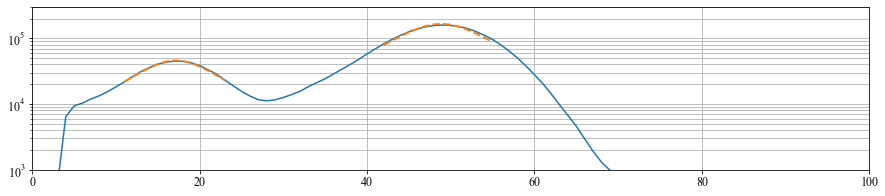

In [24]:
fig, ax = plt.subplots(figsize=(15,3))
ax.semilogy(spectra.Am241)
params = am241_peaks[['channel', 'fwhm', 'maximum', 'base']].to_numpy()
for i in range(am241_peaks.shape[0]):
    channel, fwhm, maximum, base = params[i,:]
    fit_x = np.arange(np.round(channel-fwhm/2), np.round(channel+fwhm/2)+1)
    fit_y = lorentzian(fit_x, channel, fwhm, maximum, base)
    ax.plot(fit_x, fit_y, color='tab:orange', linestyle='--', linewidth=2)
ax.set_xlim(0, 100)
ax.set_ylim(bottom=1e3)
ax.grid(True, which='both')

## Co-60 spectrum

In [25]:
slices = [slice(50, 90), slice(1020, 1140), slice(1180, 1300)]
(channels, params, delta_params,
 fits, residuals, r_squared) = fit_peaks(spectra.Co60, slices)

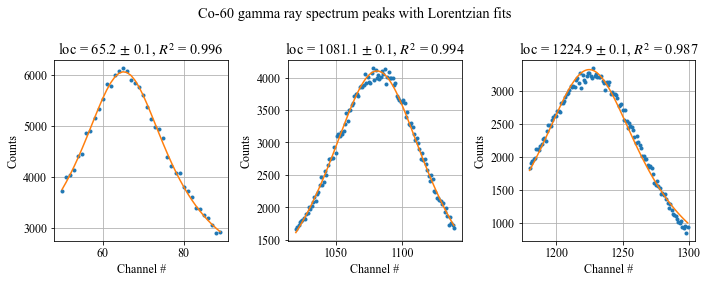

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

for i, ax, in enumerate(axes.ravel()):
    ax.plot(channels[i], spectra.Co60[slices[i]], marker='.', linestyle='')
    ax.plot(channels[i], fits[i])
    ax.grid()
    title = (
        'loc = {:.1f} $\\pm$ {:.1f}, $R^2$ = {:.3f}'
    ).format(params[i,0], delta_params[i,0], r_squared[i])
    ax.set(xlabel='Channel #', ylabel='Counts', title=title)

fig.suptitle('Co-60 gamma ray spectrum peaks with Lorentzian fits')
fig.tight_layout()

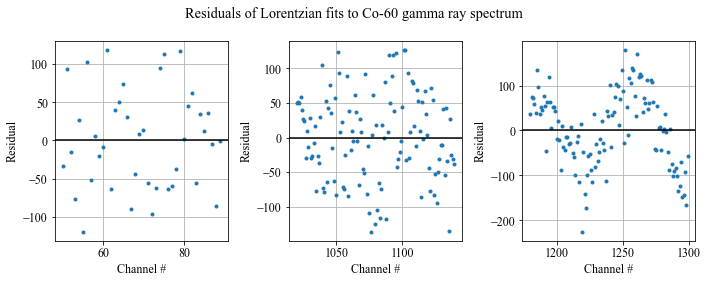

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

for i, ax, in enumerate(axes.ravel()):
    ax.plot(channels[i], spectra.Co60[slices[i]] - fits[i],
            marker='.', linestyle='')
    ax.axhline(0, color='k')
    ax.grid()
    ax.set(xlabel='Channel #', ylabel='Residual')

fig.suptitle('Residuals of Lorentzian fits to Co-60 gamma ray spectrum')
fig.tight_layout()

In [28]:
co60_peaks = pd.DataFrame({
    'channel': params[:,0], 'delta_channel': delta_params[:,0],
    'fwhm': params[:,1], 'delta_fwhm': delta_params[:,1],
    'maximum': params[:,2], 'base': params[:,3],
    'energy': np.array([74.969, 1173.208, 1332.491]),
    'delta_energy': np.array([0.005, 0.025, 0.041]),
    'r_squared': r_squared,
    'isotope': np.full(params.shape[0], 'Co60')
})
co60_peaks

,channel,delta_channel,fwhm,delta_fwhm,maximum,base,energy,delta_energy,r_squared,isotope
0,65.193656,0.075985,27.251589,0.708049,4165.156752,1.891242e+03,74.969,0.005,0.995892,Co60
1,1081.147891,0.111134,98.488181,1.927114,4100.383763,2.225090e-16,1173.208,0.025,0.993829,Co60
2,1224.883834,0.139475,97.376760,1.446220,3323.142269,1.957829e-12,1332.491,0.041,0.987397,Co60


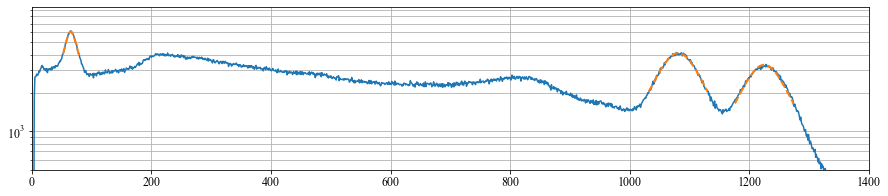

In [29]:
fig, ax = plt.subplots(figsize=(15,3))
ax.semilogy(spectra.Co60)
params = co60_peaks[['channel', 'fwhm', 'maximum', 'base']].to_numpy()
for i in range(co60_peaks.shape[0]):
    channel, fwhm, maximum, base = params[i,:]
    fit_x = np.arange(np.round(channel-fwhm/2), np.round(channel+fwhm/2)+1)
    fit_y = lorentzian(fit_x, channel, fwhm, maximum, base)
    ax.plot(fit_x, fit_y, color='tab:orange', linestyle='--', linewidth=2)
ax.set_xlim(0, 1400)
ax.set_ylim(bottom=0.5e3)
ax.grid(True, which='both')

## Ba-133 spectrum

In [30]:
slices = [slice(10, 28), slice(55, 80), slice(110, 200)]
(channels, params, delta_params,
 fits, residuals, r_squared) = fit_peaks(spectra.Ba133, slices)

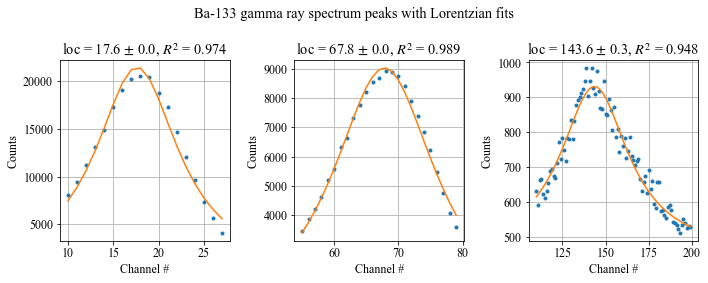

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

for i, ax, in enumerate(axes.ravel()):
    ax.plot(channels[i], spectra.Ba133[slices[i]], marker='.', linestyle='')
    ax.plot(channels[i], fits[i])
    ax.grid()
    title = (
        'loc = {:.1f} $\\pm$ {:.1f}, $R^2$ = {:.3f}'
    ).format(params[i,0], delta_params[i,0], r_squared[i])
    ax.set(xlabel='Channel #', ylabel='Counts', title=title)

fig.suptitle('Ba-133 gamma ray spectrum peaks with Lorentzian fits')
fig.tight_layout()

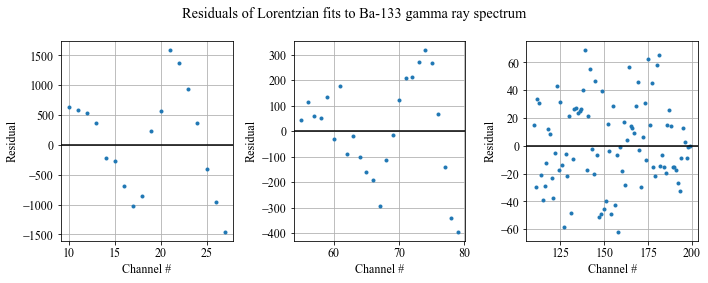

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

for i, ax, in enumerate(axes.ravel()):
    ax.plot(channels[i], spectra.Ba133[slices[i]] - fits[i],
            marker='.', linestyle='')
    ax.axhline(0, color='k')
    ax.grid()
    ax.set(xlabel='Channel #', ylabel='Residual')

fig.suptitle('Residuals of Lorentzian fits to Ba-133 gamma ray spectrum')
fig.tight_layout()

In [33]:
ba133_peaks = pd.DataFrame({
    'channel': params[:,0], 'delta_channel': delta_params[:,0],
    'fwhm': params[:,1], 'delta_fwhm': delta_params[:,1],
    'maximum': params[:,2], 'base': params[:,3],
    'energy': np.array([30.8507, 80.998, 160.605]),
    'delta_energy': np.array([0.0005, 0.008, 0.015]),
    'r_squared': r_squared,
    'isotope': np.full(params.shape[0], 'Ba133')
})
ba133_peaks

,channel,delta_channel,fwhm,delta_fwhm,maximum,base,energy,delta_energy,r_squared,isotope
0,17.620557,0.015213,11.118815,0.141802,21483.166185,3.062361e-13,30.8507,0.0005,0.974376,Ba133
1,67.813271,0.033662,19.940759,0.529172,9026.137479,1.970847e-16,80.9980,0.0080,0.989200,Ba133
2,143.578445,0.336076,47.847273,2.353783,476.290201,4.543976e+02,160.6050,0.0150,0.947719,Ba133


In [34]:
slice_ = slice(225, 375)
channels = np.arange(225, 375)

p0 = (280, 50, 2000, 0, 330, 50, 4000)
params, cov = curve_fit(
    double_lorentzian, xdata=channels,
    ydata=spectra.Ba133[slice_], sigma=np.sqrt(spectra.Ba133[slice_]),
    absolute_sigma=True, p0=p0,
    bounds=([-np.inf, -np.inf, -np.inf, 0, -np.inf, -np.inf, -np.inf], np.inf))
delta_params = np.sqrt(np.diag(cov))

fit = double_lorentzian(channels, *params)
residuals = spectra.Ba133[slice_] - fit
ss_res = np.sum(residuals**2)
ss_tot = np.sum((spectra.Ba133[slice_]
                 - np.mean(spectra.Ba133[slice_]))**2)

r_squared = 1 - ss_res/ss_tot

Text(0.5, 1.01, 'Ba-133 gamma ray spectrum peaks with Lorentzian fits')

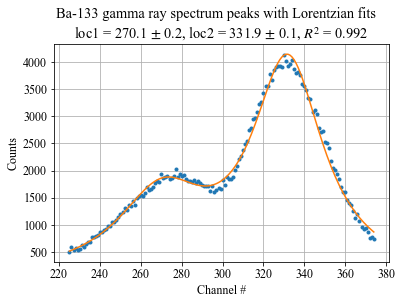

In [35]:
fig, ax = plt.subplots()
ax.plot(spectra.Ba133[slice_], '.', linestyle='')
ax.plot(channels, fit)
ax.grid()
title = (
    'loc1 = {:.1f} $\\pm$ {:.1f}, loc2 = {:.1f} $\\pm$ {:.1f}, '
    '$R^2$ = {:.3f}'
).format(params[0], delta_params[0], params[4], delta_params[4], r_squared)
ax.set(xlabel='Channel #', ylabel='Counts', title=title)
fig.suptitle('Ba-133 gamma ray spectrum peaks with Lorentzian fits', y=1.01)

Text(0.5, 0.98, 'Residuals of Lorentzian fits to Ba-133 gamma ray spectrum')

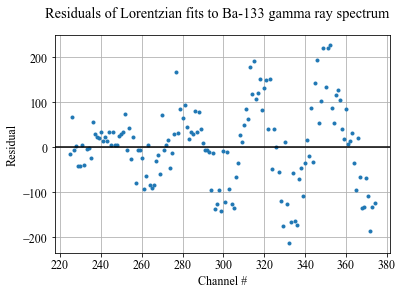

In [36]:
fig, ax = plt.subplots()
ax.plot(spectra.Ba133[slice_] - fit, '.', linestyle='')
ax.axhline(0, color='k')
ax.grid()
ax.set(xlabel='Channel #', ylabel='Residual')
fig.suptitle('Residuals of Lorentzian fits to Ba-133 gamma ray spectrum')

In [37]:
ba133_peaks = ba133_peaks.append(
    pd.DataFrame({'channel': [params[0], params[4]],
                  'delta_channel': [delta_params[0], delta_params[4]],
                  'fwhm': [params[1], params[5]],
                  'delta_fwhm': [delta_params[1], delta_params[5]],
                  'maximum': [params[2], params[6]],
                  'base': [params[3], params[3]],
                  'energy': np.array([302.851, 356.005]),
                  'delta_energy': np.array([0.015, 0.017]),
                  'r_squared': r_squared,
                  'isotope': np.full(2, 'Ba133')})
)
ba133_peaks = ba133_peaks.reset_index(drop=True)
ba133_peaks

,channel,delta_channel,fwhm,delta_fwhm,maximum,base,energy,delta_energy,r_squared,isotope
0,17.620557,0.015213,11.118815,0.141802,21483.166185,3.062361e-13,30.8507,0.0005,0.974376,Ba133
1,67.813271,0.033662,19.940759,0.529172,9026.137479,1.970847e-16,80.9980,0.0080,0.989200,Ba133
2,143.578445,0.336076,47.847273,2.353783,476.290201,4.543976e+02,160.6050,0.0150,0.947719,Ba133
3,270.148166,0.225049,52.763131,0.968612,1454.095860,1.521326e-16,302.8510,0.0150,0.992047,Ba133
4,331.856088,0.091547,42.071673,0.334869,3916.557301,1.521326e-16,356.0050,0.0170,0.992047,Ba133


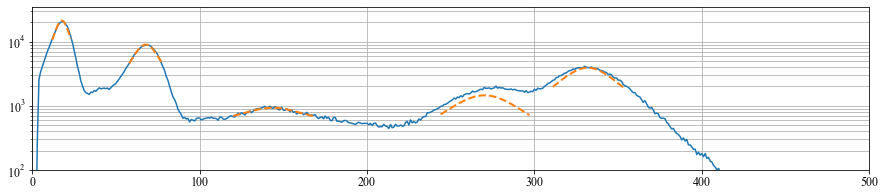

In [38]:
fig, ax = plt.subplots(figsize=(15,3))
ax.semilogy(spectra.Ba133)
params = ba133_peaks[['channel', 'fwhm', 'maximum', 'base']].to_numpy()
for i in range(ba133_peaks.shape[0]):
    channel, fwhm, maximum, base = params[i,:]
    fit_x = np.arange(np.round(channel-fwhm/2), np.round(channel+fwhm/2)+1)
    fit_y = lorentzian(fit_x, channel, fwhm, maximum, base)
    ax.plot(fit_x, fit_y, color='tab:orange', linestyle='--', linewidth=2)
ax.set_xlim(0, 500)
ax.set_ylim(bottom=100)
ax.grid(True, which='both')

## Saving the peak parameters

In [39]:
peaks = eu152_peaks.append([na22_peaks, cs137_peaks,
                            am241_peaks, co60_peaks, ba133_peaks])
peaks = peaks.sort_values(['isotope', 'channel']).reset_index(drop=True)
peaks.to_csv('fit_peaks.csv', index=False)
peaks

,channel,delta_channel,fwhm,delta_fwhm,maximum,base,energy,delta_energy,r_squared,isotope
0,17.165727,0.009928,11.666036,0.090445,46166.266450,6.923103e-20,26.3450,0.0010,0.996849,Am241
1,48.849298,0.005958,13.124423,0.065028,165959.481237,4.532420e-10,59.5370,0.0010,0.979833,Am241
2,17.620557,0.015213,11.118815,0.141802,21483.166185,3.062361e-13,30.8507,0.0005,0.974376,Ba133
3,67.813271,0.033662,19.940759,0.529172,9026.137479,1.970847e-16,80.9980,0.0080,0.989200,Ba133
4,143.578445,0.336076,47.847273,2.353783,476.290201,4.543976e+02,160.6050,0.0150,0.947719,Ba133
5,270.148166,0.225049,52.763131,0.968612,1454.095860,1.521326e-16,302.8510,0.0150,0.992047,Ba133
6,331.856088,0.091547,42.071673,0.334869,3916.557301,1.521326e-16,356.0050,0.0170,0.992047,Ba133
7,65.193656,0.075985,27.251589,0.708049,4165.156752,1.891242e+03,74.9690,0.0050,0.995892,Co60
8,1081.147891,0.111134,98.488181,1.927114,4100.383763,2.225090e-16,1173.2080,0.0250,0.993829,Co60
9,1224.883834,0.139475,97.376760,1.446220,3323.142269,1.957829e-12,1332.4910,0.0410,0.987397,Co60
